In [2]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import tqdm
import torch
import torch.nn as nn
import dgl

Using backend: pytorch


In [3]:
import sys
sys.path.append("..")


from phenixml.fragmentation.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import BondFragmenter, AngleFragmenter
from phenixml.labelers.fragment_labelers import BondFragmentLabeler,AngleFragmentLabeler
from phenixml.graphs.molgraph import MolGraph
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint
from phenixml.visualization.plotting import plot_geom_eval

In [4]:
# # get molecules
# mol_dir = "/dev/shm/cschlick/geostd_passed/"
# containers = MolContainer.from_folder(mol_dir,max_files=500)


mol_dir = "/dev/shm/cschlick/COD_processing/COD_finalized"
containers = MolContainer.from_folder(mol_dir,suffix=".mol",max_files=20000)

containers = [MolContainer.from_rdkit(Chem.RemoveHs(container.rdkit_mol)) for container in containers]



In [5]:
molgraph = MolGraph(mol_container=containers[0],
                        fragmenter=BondFragmenter(),
                        labeler=BondFragmentLabeler(),
                        ignore_hydrogens=False)

In [6]:
molgraphs = []
for container in tqdm.tqdm(containers):
  try:
    molgraph = MolGraph(mol_container=container,
                        fragmenter=BondFragmenter(),
                        labeler=BondFragmentLabeler(),
                        ignore_hydrogens=False)
    molgraphs.append(molgraph)
  except:
    pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19701/19701 [06:22<00:00, 51.52it/s]


In [17]:
print("hi")

hi


In [8]:
batch = dgl.batch([molgraph.heterograph for molgraph in molgraphs])

In [14]:
# model

#mine
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import JanossyReadout


n_units = 128
n_layers = 3
fragment_size = 2
feature_units = molgraphs[0].heterograph.nodes["atom"].data["h0"].shape[1]

config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
  
sc = lambda in_feats,out_feats: dgl.nn.pytorch.conv.sageconv.SAGEConv(in_feats,out_feats,"mean",bias=True) # dgl sageconv layer

message_passing = MessagePassing(
    feature_units=feature_units,
    layer=sc, # use SAGEConv implementation in DGL
    #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
    config=config,
    # atom_node_name = node_name,
    # fragment_name = frag_name,
) 


n_units = 128
n_layers = 2
config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
readout = JanossyReadout(
    in_features=n_units, config=config,
    out_features={"pred":1},
    atom_node_name = "atom",
    fragment_name = "fragment",
    fragment_size = fragment_size
)
model = nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()


In [15]:
gpuid = 0
batch = batch.to("cuda:"+str(gpuid))
model = model.to("cuda:"+str(gpuid))


In [11]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(batch.nodes["fragment"].data["ref"]))
train_mask,test_mask = train_test_split(inds,test_size=0.2)

In [16]:
epoch_losses = []
n_epoch=1000
avg_loss = "inf"

for epoch in tqdm.tqdm(range(n_epoch)):
    
  g = model(batch)
  loss = metric(g.nodes["fragment"].data["ref"][train_mask],
                g.nodes["fragment"].data["pred"][train_mask])
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.81it/s]


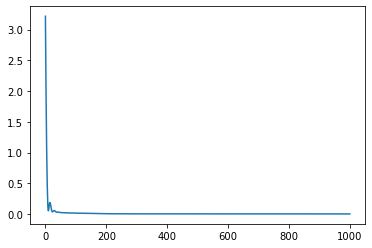

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def to_np(tensor):
  return tensor.detach().cpu().numpy()

plt.plot(epoch_losses)
#plt.plot(loss_history_n3[10:])

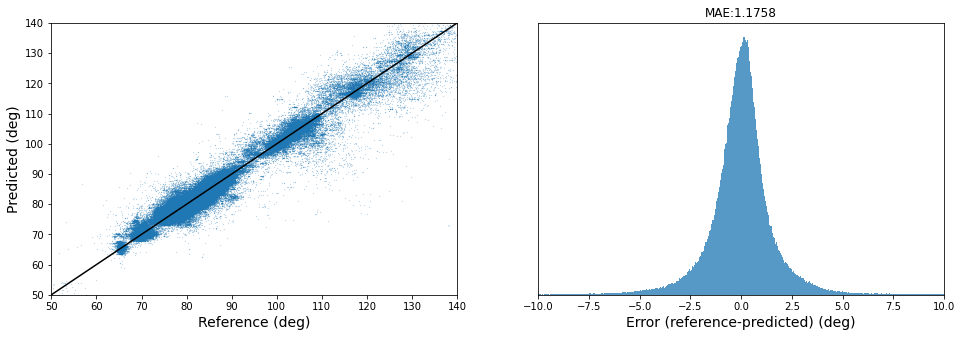

In [19]:
a,b = g.nodes["fragment"].data["ref"][train_mask], g.nodes["fragment"].data["pred"][train_mask],
a,b = to_np(a).flatten(),to_np(b).flatten()
a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

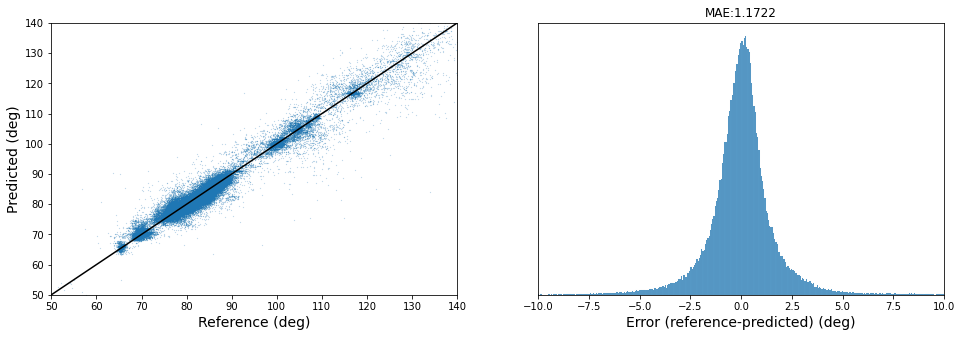

In [20]:
a,b = g.nodes["fragment"].data["ref"][test_mask], g.nodes["fragment"].data["pred"][test_mask],
a,b = to_np(a).flatten(),to_np(b).flatten()
a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")